In [36]:
import image_registration as IR
import time

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.wcs import WCS
from astropy.wcs import utils
import numpy as np
plt.style.use(astropy_mpl_style)

In [4]:
path1 = r'20190405T110036.fits.fz'
path2 = r'20190405T110332.fits.fz'
path3 = r'20190405T110633.fits.fz'

In [5]:
def get_hdul_imgHDU_and_wcs(path_to_fits):
    hdul = fits.open(path_to_fits)
    image_hdu = hdul[1]
    wcs = WCS(image_hdu.header)
    return hdul,image_hdu,wcs

In [6]:
hdul1,image_hdu1,wcs1 = get_hdul_imgHDU_and_wcs(path1)
hdul2,image_hdu2,wcs2 = get_hdul_imgHDU_and_wcs(path2)
hdul3,image_hdu3,wcs3 = get_hdul_imgHDU_and_wcs(path3)

Try and use image_registration to match overlapping areas.

In [7]:
wcs_overlap = WCS(IR.FITS_tools.header_overlap(image_hdu1.header,image_hdu2.header))

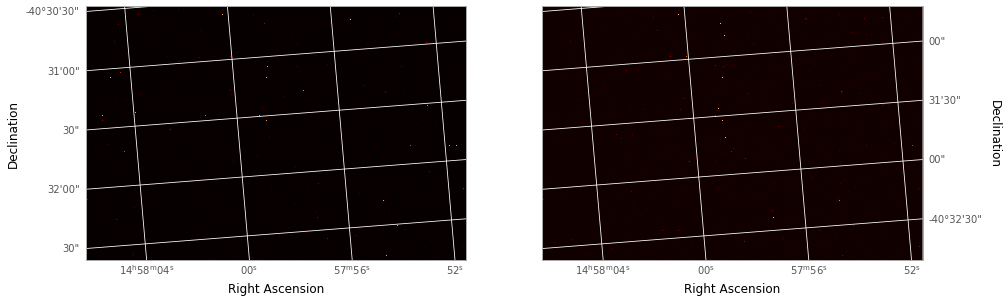

In [8]:
plt.rcParams['figure.figsize'] = [15,15]
ax1 = plt.subplot(1,2,1, projection=wcs_overlap)
ax1.imshow(image_hdu1.data, origin='lower')
ax1.coords.grid(color='white')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')



ax2 = plt.subplot(1,2,2, projection=wcs_overlap)
ax2.imshow(image_hdu2.data, origin='lower')
ax2.coords.grid(color='white')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')

Once we get the overlapping WCS, we need to reproject the images from their wcs to the overlapped_wcs but for that we again have
to use reproject which doesn't support SIP headers.

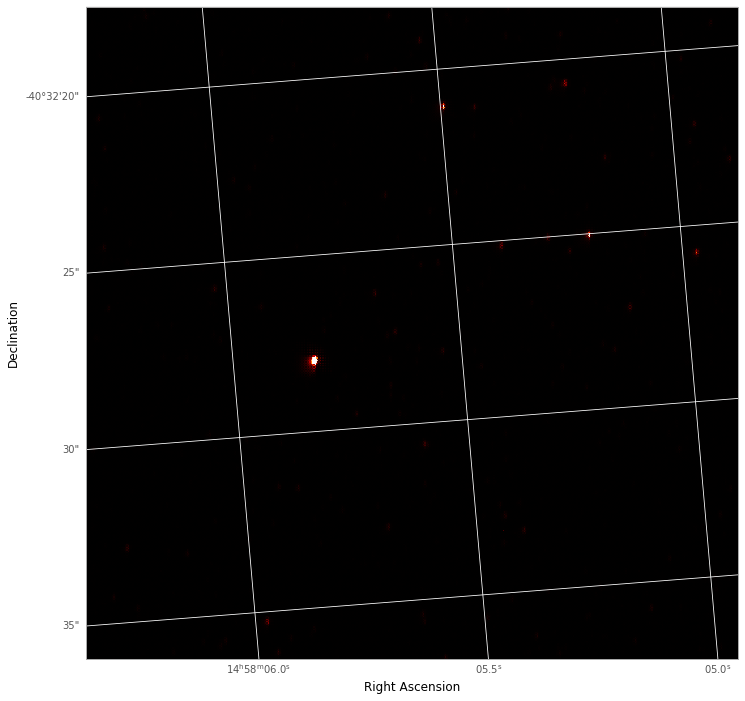

In [9]:
plt.rcParams['figure.figsize'] = [12,12]
ax1 = plt.subplot(111, projection=wcs_overlap)
ax1.imshow(image_hdu1.data[0:500,0:500], origin='lower')
ax1.imshow(image_hdu2.data[0:500,0:500], origin='lower')
ax1.imshow(image_hdu3.data[0:500,0:500], origin = 'lower')
ax1.coords.grid(color='white')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')


Apparently ds9 uses a transformation matrix to carry out translation,scale and roatation. This sounds like an Affine transform so we'll use that. Source: William Joye of ds9

In [10]:
from skimage.transform import PiecewiseAffineTransform, warp

In [16]:
reference_pixels = np.array([[2604,1700],[2602,1712],[2580,1722],[1300,1600]]) #[[x,y]] 

In [18]:
reference_world_coordinates = wcs1.all_pix2world(reference_pixels,1)
# Get pixel values in images 2 and 3 with the same coordinates
pixels_with_reference_coords_1 = wcs2.all_world2pix(reference_world_coordinates,1)

In [42]:
src = pixels_with_reference_coords_1
dst = reference_pixels
# Aligning image_2 to image_1
tform = PiecewiseAffineTransform()
x = time.time()
tform.estimate(src,dst)
y = time.time()
print('Time taken is {0} seconds'.format(y-x))

Time taken is 0.015992403030395508 seconds


In [43]:
x = time.time()
resulting_image = warp(image_hdu2.data,tform)
y = time.time()
print('Time taken is {0} seconds'.format(y-x))

Time taken is 8.250670194625854 seconds


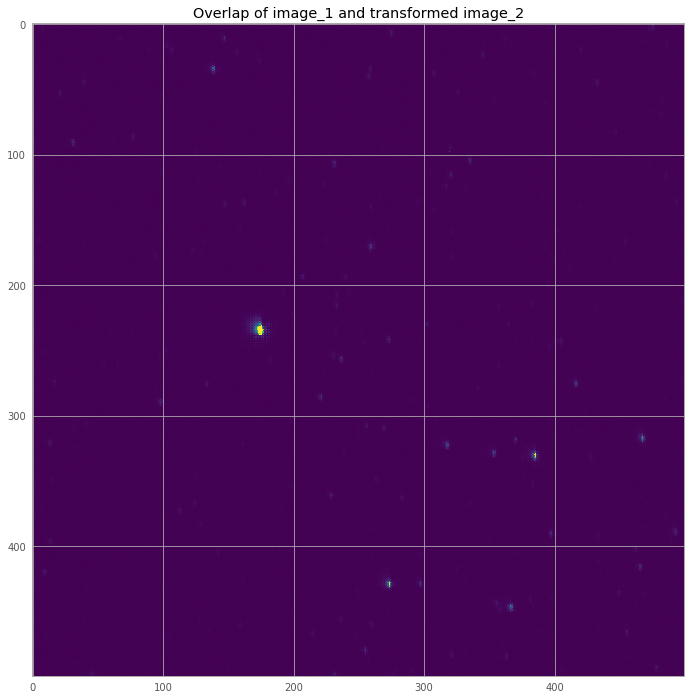

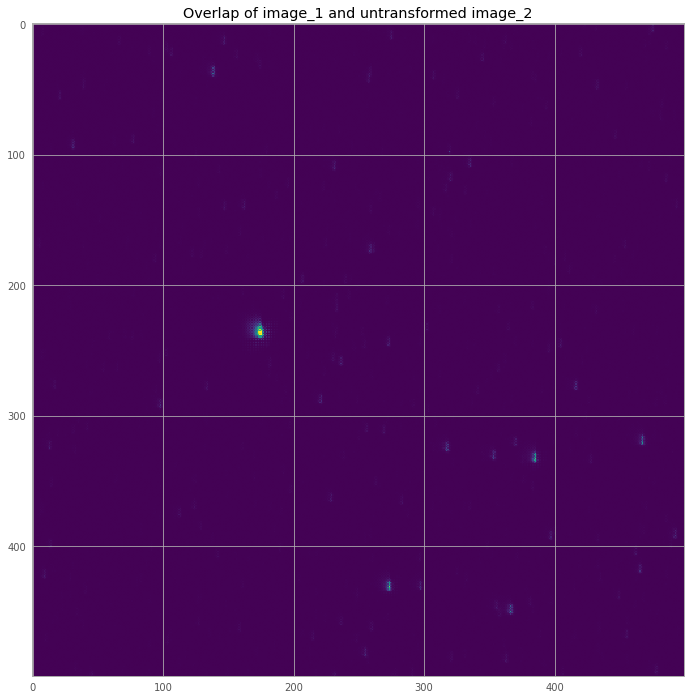

In [44]:
plt.imshow((resulting_image[0:500,0:500]+image_hdu1.data[0:500,0:500])/2,cmap='viridis')
plt.title('Overlap of image_1 and transformed image_2')
plt.figure()
plt.title('Overlap of image_1 and untransformed image_2')
plt.imshow((image_hdu2.data[0:500,0:500]+image_hdu1.data[0:500,0:500])/2,cmap='viridis')

(3476, 5208)